# Data Exploration

In this notebook, I dive into the ECG dataset to get a better understanding of its structure and characteristics. My main goal here is to uncover patterns and insights that will be useful when building models later on.

#### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ast
from os.path import join

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind

from utils.data_preprocessing import *
from utils.ecg_visualization import *

pd.set_option("display.max_columns", None)

2024-08-27 15:50:12.626619: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### PTB-XL Data Loading

Throughout the project, I focus on ECGs with sampling rate 100 for efficiency in computing.

In [3]:
data_path = "../data/"
sampling_rate = 100

In [4]:
Y = pd.read_csv(join(data_path, "raw/ptbxl_database.csv"), index_col="ecg_id").drop(columns="filename_hr")
Y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21801 entries, 1 to 21837
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21801 non-null  float64
 1   age                           21801 non-null  float64
 2   sex                           21801 non-null  int64  
 3   height                        6975 non-null   float64
 4   weight                        9422 non-null   float64
 5   nurse                         20326 non-null  float64
 6   site                          21783 non-null  float64
 7   device                        21801 non-null  object 
 8   recording_date                21801 non-null  object 
 9   report                        21801 non-null  object 
 10  scp_codes                     21801 non-null  object 
 11  heart_axis                    13331 non-null  object 
 12  infarction_stadium1           5613 non-null   object 
 13  infarc

In [5]:
print(f"There are {Y.shape[0]:,} ECGs for {Y.patient_id.nunique():,} patients")

There are 21,801 ECGs for 18,869 patients


In [6]:
Y[Y.select_dtypes(include="bool").columns] = Y.select_dtypes(include="bool").astype(int)
Y = Y.astype({"patient_id": int})

#### Design choices

I noticed several boolean indicators at the end of the dataset that flag specific ECG features. However, these indicators are not documented in the PhysioNet description, which only covers the first 28 columns. To maintain focus and ensure the use of well-documented data, I will exclude these indicators from my analysis and modeling. Instead, I'll concentrate on the SCP data, which is thoroughly documented and better understood.

In [7]:
Y = Y.drop(
    columns=[
        "RS-LVH",
        "S12-LVH",
        "R56-LVH",
        "QRS-LVH",
        "LI-LVH",
        "SLI-LVH",
        "QRS-CLBB",
        "ST-ELEV-MI",
        "ST-DEPR-MI",
        "Q-ISC",
        "Q-ISC-QPeak",
        "Q-ISC-V2V3",
        "Q-ISC-RPeak",
        "STRAIN",
        "MI-ALL",
    ]
)

In [8]:
Y.describe()

,patient_id,age,sex,height,weight,nurse,site,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,strat_fold
count,21801.000000,21801.000000,21801.000000,6975.000000,9422.000000,20326.000000,21783.000000,12421.000000,21801.000000,21801.000000,21801.000000,21801.000000
mean,11250.554287,62.769781,0.479106,166.703226,70.996391,2.291745,1.545012,0.746075,0.025458,0.312509,0.736572,5.503142
std,6235.025560,32.307421,0.499575,10.866804,15.878365,3.254033,4.172799,1.178003,0.157514,0.463527,0.440503,2.874868
min,302.000000,2.000000,0.000000,6.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,5975.000000,50.000000,0.000000,160.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,11419.000000,62.000000,0.000000,166.000000,70.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,6.000000
75%,16608.000000,72.000000,1.000000,174.000000,80.000000,3.000000,2.000000,1.000000,0.000000,1.000000,1.000000,8.000000
max,21797.000000,300.000000,1.000000,209.000000,250.000000,11.000000,50.000000,11.000000,1.000000,1.000000,1.000000,10.000000


In [9]:
Y.isnull().mean()

patient_id                      0.000000
age                             0.000000
sex                             0.000000
height                          0.680061
weight                          0.567818
nurse                           0.067657
site                            0.000826
device                          0.000000
recording_date                  0.000000
report                          0.000000
scp_codes                       0.000000
heart_axis                      0.388514
infarction_stadium1             0.742535
infarction_stadium2             0.995275
validated_by                    0.430255
second_opinion                  0.000000
initial_autogenerated_report    0.000000
validated_by_human              0.000000
baseline_drift                  0.926655
static_noise                    0.850466
burst_noise                     0.971882
electrodes_problems             0.998624
extra_beats                     0.910600
pacemaker                       0.986652
strat_fold      

- Height and weight columns in the dataset contain a significant number of missing values. Given that these variables are not central to the primary objective of analyzing ECG data and predicting heart conditions, and the effort to impute or handle these missing values may not yield substantial benefits for the model's performance, I decided it's reasonable to exclude these columns from the analysis. This allows me to focus on more relevant and complete data for this analysis.

- For simplicity, I decided to remove the metadata columns `nurse`, `site`, `device`, `recording_date`, and `validated_by`, `initial_autogenerated_report` as they are not directly relevant to the clinical outcomes we are focusing on. Additionally, these variables could introduce bias. I also remove `report` since it was converted into the `scp-codes` column.

- I remove `second_opinion` column because it is present in only 2.5% of the data, making it too sparse to be useful for our analysis.

- I also remove `validated_by_human` since I will be using the cross-validation folds recommended by physionet where folds 9 and 10, which will be used for validation and testing, contain records with high-quality labels validated by humans.

In [10]:
Y = Y.drop(
    columns=[
        "height",
        "weight",
        "nurse",
        "site",
        "validated_by",
        "device",
        "recording_date",
        "r_peaks",
        "second_opinion",
        "validated_by_human",
        "initial_autogenerated_report",
        "report",
    ]
)

In [11]:
Y.head(3)

,patient_id,age,sex,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr
ecg_id,,,,,,,,,,,,,,,
1,15709,56.0,1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr
2,13243,19.0,0,"{'NORM': 80.0, 'SBRAD': 0.0}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr
3,20372,37.0,1,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr


#### Data Analysis

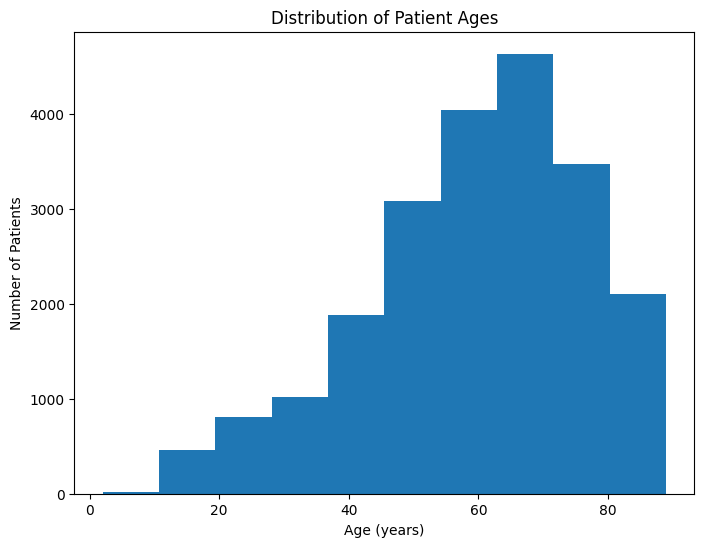

In [12]:
Y = Y.loc[Y.age < 100]

plt.figure(figsize=(8, 6))
plt.hist(Y.age)
plt.title("Distribution of Patient Ages")
plt.xlabel("Age (years)")
plt.ylabel("Number of Patients")
plt.show()

After removing outliers, the age distribution is slightly right skewed. This is expected given that there is a higher prevalence of cardiovascular disease in older people and therefore an increased amount of monitoring.

In [13]:
Y.drop_duplicates("patient_id").sex.value_counts(normalize=True)

sex
0    0.514829
1    0.485171
Name: proportion, dtype: float64

Although it is not stated directly which sex value represents male or female, physionet states that there are 52% males and 48% females, which means 0 represents males and 1 females. The data is fairly balanced between the genders.

In [14]:
Y.columns

Index(['patient_id', 'age', 'sex', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'baseline_drift',
       'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats',
       'pacemaker', 'strat_fold', 'filename_lr'],
      dtype='object')

In [15]:
Y.heart_axis.value_counts(dropna=False)

heart_axis
NaN     8341
MID     7649
LAD     3678
ALAD    1354
RAD      219
ARAD     118
AXL       95
AXR       51
SAG        3
Name: count, dtype: int64

In [16]:
Y.infarction_stadium1.value_counts(dropna=False), Y.infarction_stadium2.value_counts(dropna=False)

(infarction_stadium1
 NaN               16018
 unknown            3372
 Stadium II-III      935
 Stadium III         933
 Stadium I           161
 Stadium II           84
 Stadium I-II          5
 Name: count, dtype: int64,
 infarction_stadium2
 NaN            21408
 Stadium III       62
 Stadium I         19
 Stadium II        19
 Name: count, dtype: int64)

In [17]:
Y["infarction_stadium1"] = Y["infarction_stadium1"].replace("unknown", np.nan)

Heart axis and infarction stadium will help us ensure that normal ECGs do not have contradictions in their data (e.g. normal ECG with a known infarction stadium).

We will use the columns `baseline_drift`, `static_noise`, `burst_noise`, `electrodes_problems`, `extra_beats`, `pacemaker` during preprocessing to ensure data quality.

#### Data Visualization

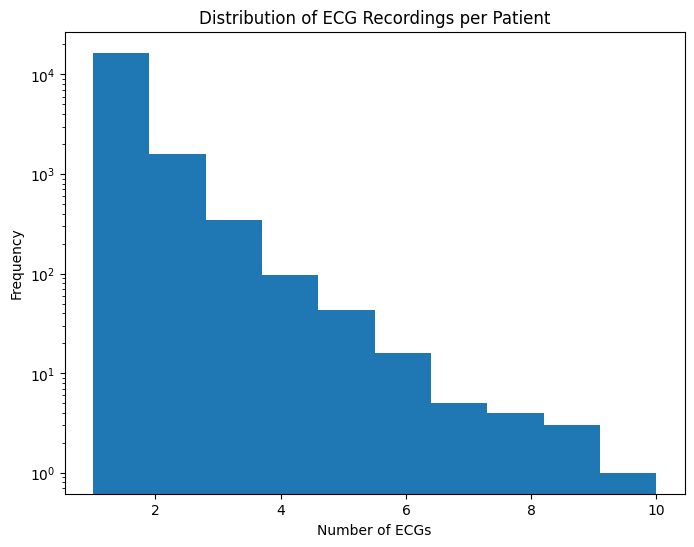

In [18]:
ecg_per_patient = Y.groupby("patient_id").size()

plt.figure(figsize=(8, 6))
plt.hist(ecg_per_patient)
plt.yscale("log")
plt.title("Distribution of ECG Recordings per Patient")
plt.xlabel("Number of ECGs")
plt.ylabel("Frequency")
plt.show()

There are more than 1 ECG per patient. It is important during model training to ensure that train/val/test sets do not have patient overlaps. The physionet splits guarantee this.

Let's visualize ECGs of different SCP labels in a similar fashion as in a clinical setting.

Annotations (SCP Codes) for Patient ID 15709, ECG ID 1: {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}


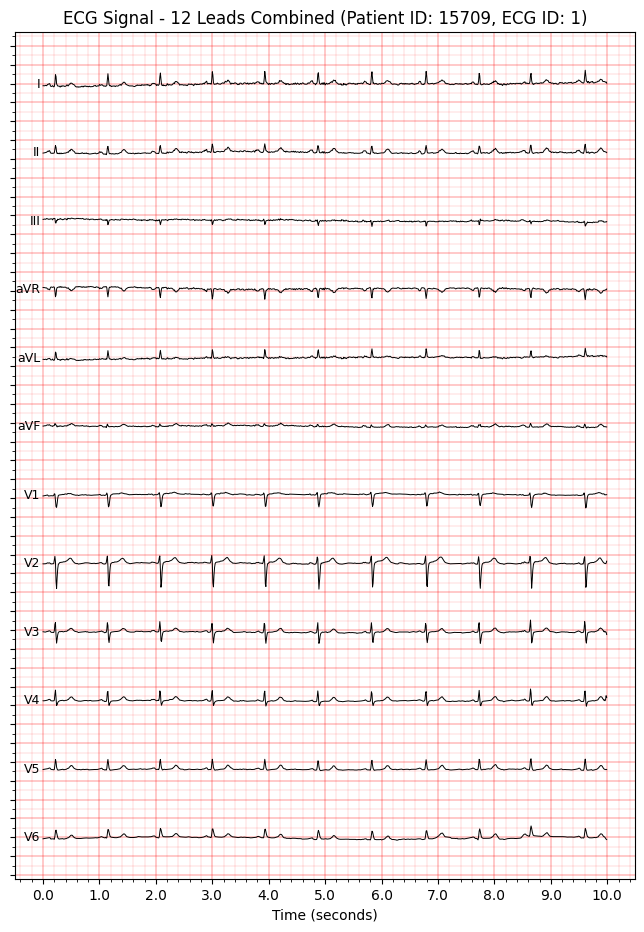

Annotations (SCP Codes) for Patient ID 11275, ECG ID 8: {'IMI': 35.0, 'ABQRS': 0.0, 'SR': 0.0}


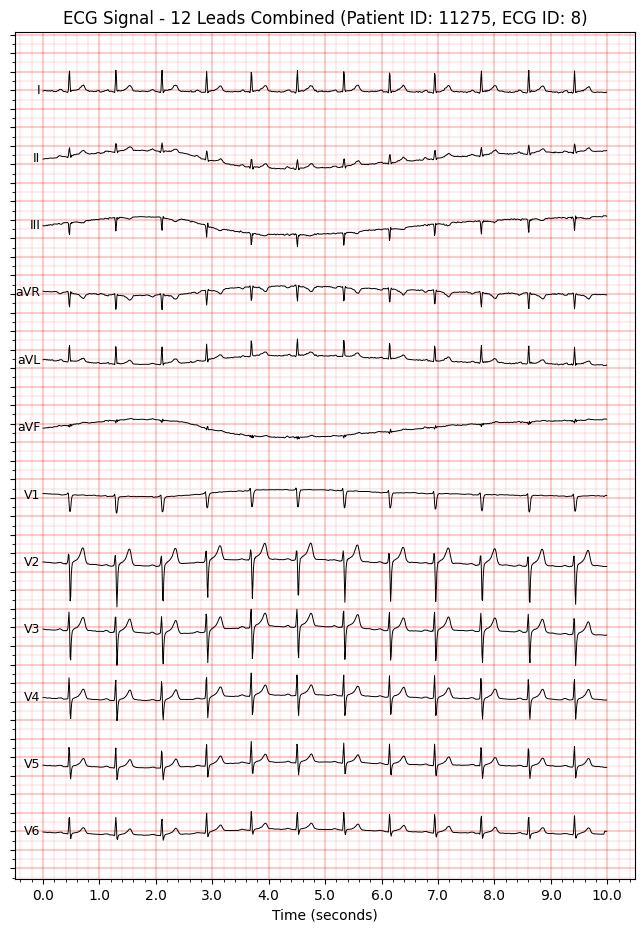

Annotations (SCP Codes) for Patient ID 13619, ECG ID 17: {'AFLT': 100.0, 'ABQRS': 0.0, 'AFIB': 0.0}


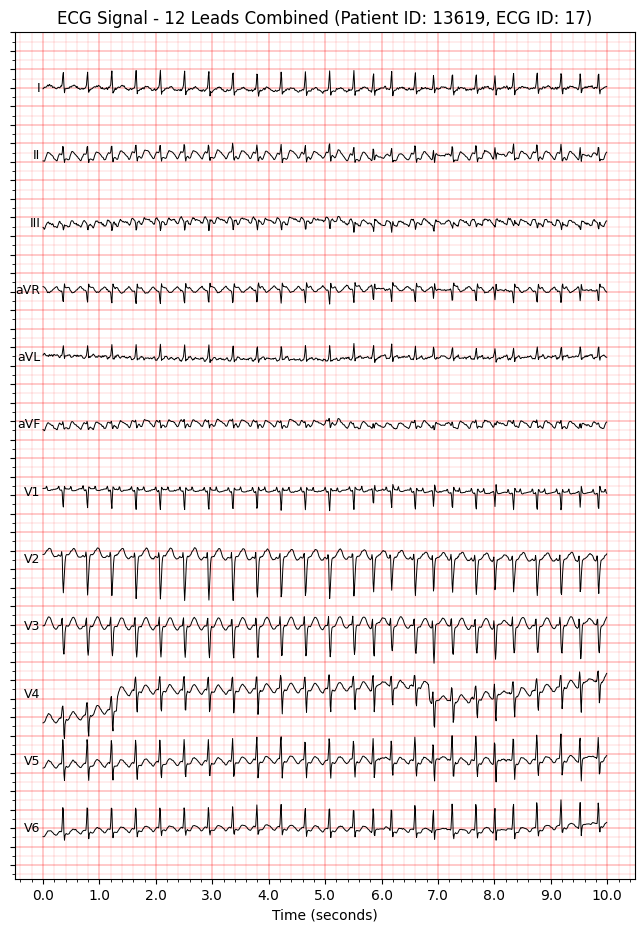

In [19]:
load_and_plot_ecg(0, Y, sampling_rate=100, path=join(data_path, "raw"))
load_and_plot_ecg(7, Y, sampling_rate=100, path=join(data_path, "raw"))
load_and_plot_ecg(16, Y, sampling_rate=100, path=join(data_path, "raw"))

#### Feature analysis

I aggregated diagnostic codes following the functions suggested by physionet. I added a requirement that the diagnosis was highly likely (>= 80% chance), to ensure data quality. This parameter could be tuned during model training, but I will not focus on it.

In [20]:
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
agg_df = pd.read_csv(join(data_path, "raw/scp_statements.csv"), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
Y["diagnostic_class"] = Y.scp_codes.apply(aggregate_diagnostic, args=(agg_df, "diagnostic_class", 80.0))
Y = Y.loc[Y["diagnostic_class"] != ""]

In [21]:
Y["diagnostic_class"].value_counts()

diagnostic_class
NORM              8585
STTC              2624
CD                2478
MI                1554
MI|CD              766
STTC|HYP           555
STTC|CD            503
NORM|CD            320
MI|STTC            319
HYP                248
HYP|CD             204
STTC|HYP|CD        177
MI|HYP|STTC        146
MI|CD|STTC         105
MI|HYP|CD|STTC      72
MI|HYP|CD           69
MI|HYP              58
STTC|MI              4
STTC|HYP|MI          3
NORM|STTC|CD         1
STTC|HYP|MI|CD       1
NORM|HYP             1
Name: count, dtype: int64

In [22]:
diagnostic_superclass_df = Y["diagnostic_class"].str.get_dummies()
diagnostic_superclass_df.mean()

CD      0.249880
HYP     0.081626
MI      0.164795
NORM    0.473953
STTC    0.239983
dtype: float64

Patients in this dataset seem to commonly have comorbidities. I see that patients diagnosed as normal can also have high likelihood for other diseases. I will treat this issue during preprocessing.

In [23]:
Y = pd.concat([Y, diagnostic_superclass_df], axis=1)

In [24]:
Y.columns

Index(['patient_id', 'age', 'sex', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'baseline_drift',
       'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats',
       'pacemaker', 'strat_fold', 'filename_lr', 'diagnostic_class', 'CD',
       'HYP', 'MI', 'NORM', 'STTC'],
      dtype='object')

In [25]:
Y["normal_heart_axis"] = np.where(Y["heart_axis"].isin(["MID", np.nan]), 1, 0)
Y["infarction"] = np.where(Y[["infarction_stadium1", "infarction_stadium2"]].isna().sum(1) != 2, 1, 0)

In [26]:
Y["static_noise_bool"] = np.where(Y["static_noise"].isna(), 0, 1)
Y["burst_noise_bool"] = np.where(Y["burst_noise"].isna(), 0, 1)
Y["electrodes_problems_bool"] = np.where(Y["electrodes_problems"].isna(), 0, 1)
Y["extra_beats_bool"] = np.where(Y["extra_beats"].isna(), 0, 1)
Y["pacemaker_bool"] = np.where(Y["pacemaker"].isna(), 0, 1)
Y["baseline_drift_bool"] = np.where(Y["baseline_drift"].isna(), 0, 1)

In [27]:
correlation_matrix = Y[
    [
        "age",
        "sex",
        "normal_heart_axis",
        "infarction",
        "baseline_drift_bool",
        "static_noise_bool",
        "burst_noise_bool",
        "electrodes_problems_bool",
        "extra_beats_bool",
        "pacemaker_bool",
        "CD",
        "HYP",
        "MI",
        "NORM",
        "STTC",
    ]
].corr()

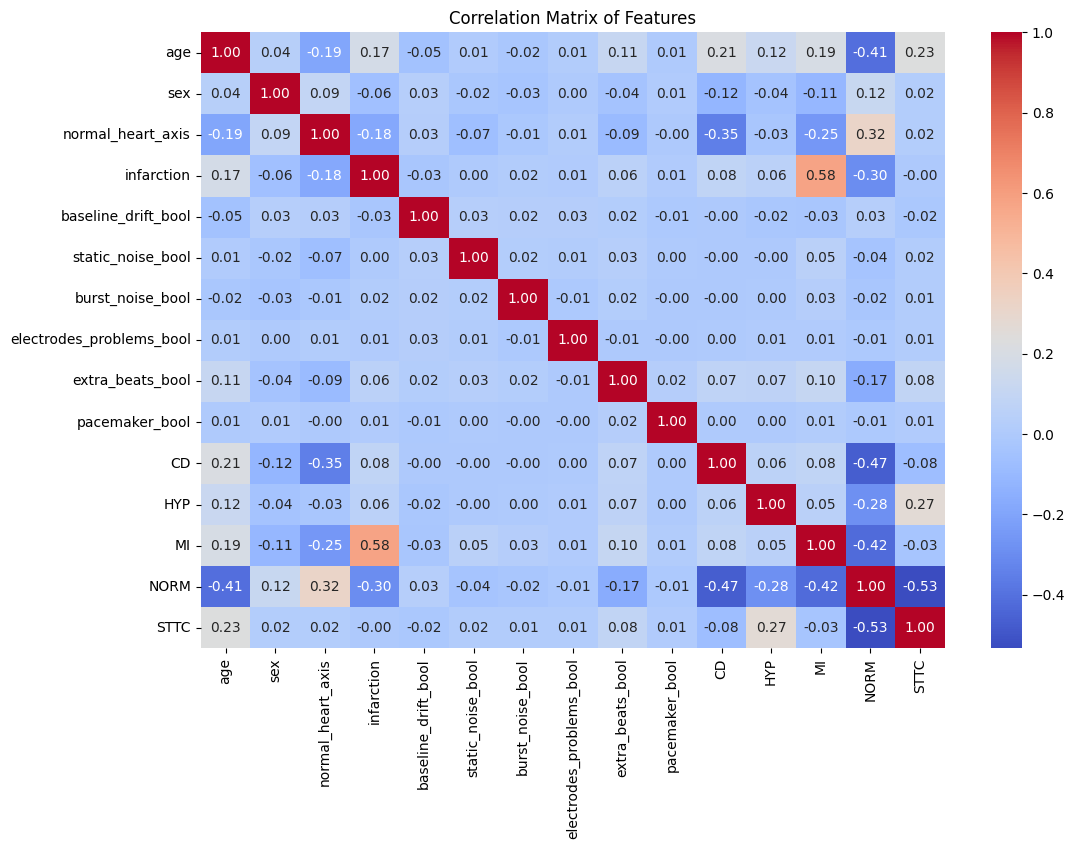

In [28]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

- Age correlates positively with conditions like CD (0.21), MI (0.19), and HYP (0.12), indicating these are more prevalent in older patients.
- MI and Infarction show a strong positive correlation (0.58), as expected.
- NORM has a strong negative correlation with CD (-0.47) and MI (-0.42), suggesting these conditions are inversely related to normal ECGs.
- STTC is negatively correlated with NORM (-0.53), reflecting that ST/T changes often indicate abnormalities.
- Normal heart axis correlates positively with NORM (0.32, which is expected) and negatively with CD (-0.35) and MI (-0.25), suggesting that deviations in heart axis are associated with these conditions.


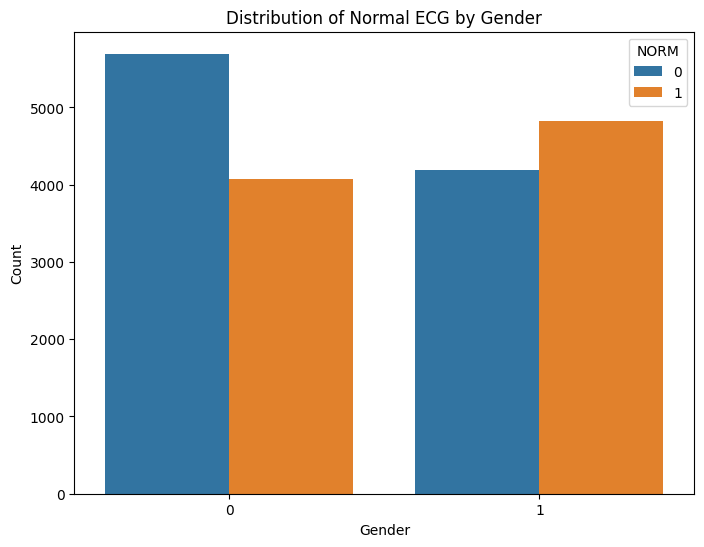

In [29]:
plt.figure(figsize=(8, 6))
sns.countplot(x="sex", hue="NORM", data=Y)
plt.title("Distribution of Normal ECG by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

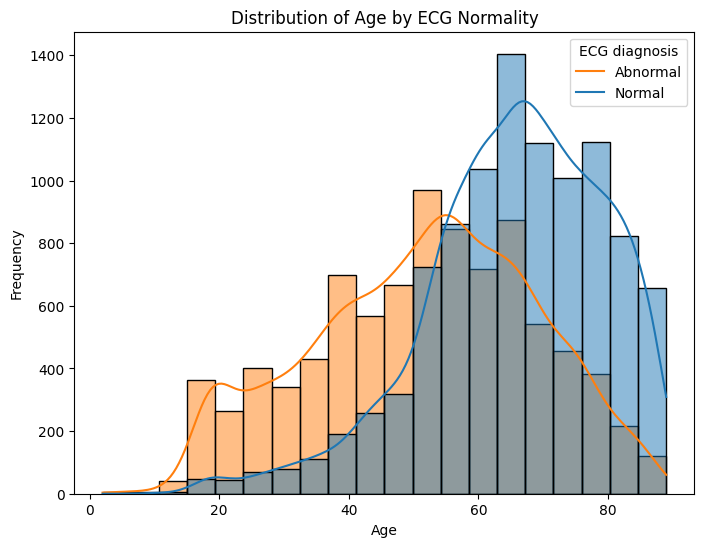

In [30]:
plt.figure(figsize=(8, 6))
sns.histplot(data=Y, x="age", hue="NORM", kde=True, bins=20)
plt.title("Distribution of Age by ECG Normality")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend(title="ECG diagnosis", labels=["Abnormal", "Normal"])
plt.show()

In [31]:
contingency_table = pd.crosstab(Y["sex"], Y["NORM"])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")

Chi-Square Statistic: 261.8628196596253
P-value: 6.73707538278752e-59


In [32]:
normal_age = Y[Y["NORM"] == 1]["age"]
abnormal_age = Y[Y["NORM"] == 0]["age"]

t_stat, p_value = ttest_ind(normal_age, abnormal_age, equal_var=False)  # T-Test
print(f"T-Test Statistic: {t_stat}")
print(f"P-value: {p_value}")

T-Test Statistic: -60.92817871547189
P-value: 0.0


In this dataset, normal ECGs are more common in individuals aged 50-70, while abnormal ECGs are more frequent in those aged 20-50. Additionally, males have a higher prevalence of abnormal ECGs, whereas females more often show normal ECGs. A Chi-Square test confirms a significant association between gender and ECG normality (p < 0.05), and a T-test indicates a significant difference in age distributions between normal and abnormal ECGs (p < 0.05).

In [33]:
Y = Y.drop(
    columns=[
        "scp_codes",
        "CD",
        "HYP",
        "MI",
        "NORM",
        "STTC",
        "normal_heart_axis",
        "infarction",
        "static_noise_bool",
        "burst_noise_bool",
        "electrodes_problems_bool",
        "extra_beats_bool",
        "pacemaker_bool",
        "baseline_drift_bool",
    ]
)

In [34]:
Y.to_csv(join(data_path, "processed/ecg_metadata.csv"))